# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import libraries
import pandas as pd

from sqlalchemy import create_engine

In [2]:
# load data from database
engine = create_engine('sqlite:///../data/data.db')
df = pd.read_sql_table("processed", con=engine)
df.head()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df.columns

Index(['id', 'message', 'original', 'genre', 'related', 'request', 'offer',
       'aid_related', 'medical_help', 'medical_products', 'search_and_rescue',
       'security', 'military', 'water', 'food', 'shelter', 'clothing', 'money',
       'missing_people', 'refugees', 'death', 'other_aid',
       'infrastructure_related', 'transport', 'buildings', 'electricity',
       'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure',
       'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold',
       'other_weather', 'direct_report'],
      dtype='object')

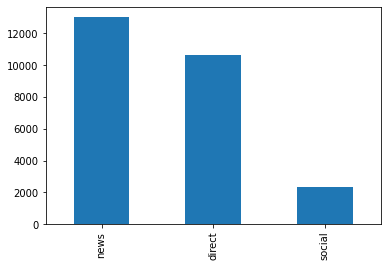

In [4]:
df["genre"].value_counts().plot.bar();

In [5]:
df["genre"].isna().mean()

0.0

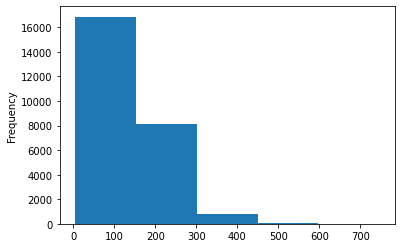

In [6]:
df[df["message"].str.len() < 750]["message"].str.len().plot.hist(bins=5);

In [7]:
df["message"].values

array(['Weather update - a cold front from Cuba that could pass over Haiti',
       'Is the Hurricane over or is it not over',
       'Looking for someone but no name', ...,
       "Proshika, operating in Cox's Bazar municipality and 5 other unions, Ramu and Chokoria, assessment, 5 kg rice, 1,5 kg lentils to 700 families.",
       'Some 2,000 women protesting against the conduct of the elections were teargassed as they tried to converge on the local electoral commission offices in the southern oil city of Port Harcourt.',
       'A radical shift in thinking came about as a result of this meeting, recognizing that HIV/AIDS is at the core of the humanitarian crisis and identifying the crisis itself as a function of the HIV/AIDS pandemic.'],
      dtype=object)

In [8]:
df.select_dtypes(include="int").drop(columns=["id"]).head()

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
X = df["message"].values

In [10]:
Y = df.select_dtypes(include="int").drop(columns=["id"])

In [11]:
X

array(['Weather update - a cold front from Cuba that could pass over Haiti',
       'Is the Hurricane over or is it not over',
       'Looking for someone but no name', ...,
       "Proshika, operating in Cox's Bazar municipality and 5 other unions, Ramu and Chokoria, assessment, 5 kg rice, 1,5 kg lentils to 700 families.",
       'Some 2,000 women protesting against the conduct of the elections were teargassed as they tried to converge on the local electoral commission offices in the southern oil city of Port Harcourt.',
       'A radical shift in thinking came about as a result of this meeting, recognizing that HIV/AIDS is at the core of the humanitarian crisis and identifying the crisis itself as a function of the HIV/AIDS pandemic.'],
      dtype=object)

In [12]:
def filter_target_columns(Y: pd.DataFrame):
    invalid_columns = []
    
    # Filter columns that have only one class.
    for column in Y.columns:
        column_values = Y[column]
        if len(pd.unique(column_values)) <= 1:
            invalid_columns.append(column)
        
    Y = Y.drop(columns=invalid_columns)
    
    return Y, invalid_columns


Y, invalid_columns = filter_target_columns(Y)
invalid_columns

[]

In [13]:
valid_targets = Y.columns
Y = Y.values

In [14]:
len(valid_targets)

35

### 2. Write a tokenization function to process your text data

In [15]:
import nltk

nltk.download(["punkt", "stopwords", "wordnet"])

[nltk_data] Downloading package punkt to /home/iusztin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/iusztin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/iusztin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [16]:
import re

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


def tokenize(text):
    # Normalize.
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    
    # Tokenize.
    tokens = word_tokenize(text)
    
    # Clean.
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatize.
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return tokens
    

In [17]:
tokenize("Weather update - a cold front from Cuba that could pass over Haiti")

['weather', 'update', 'cold', 'front', 'cuba', 'could', 'pas', 'haiti']

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier


def create_pipeline():
    pipeline = Pipeline([
        ("count", CountVectorizer(tokenizer=tokenize)),
        ("tfid", TfidfTransformer()),
        ("classifier", MultiOutputClassifier(RandomForestClassifier())),
    ], memory="./cache")
    
    return pipeline

pipeline = create_pipeline()

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [19]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, Y)

In [20]:
pipeline.fit(X_train, y_train)

KeyboardInterrupt: 

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [ ]:
from sklearn.metrics import classification_report


def evaluate_model(model, X_test, y_test, category_names):
    y_pred = model.predict(X_test)

    num_classes = len(category_names)
    for column_idx in range(num_classes):
        c_test = y_test[:, column_idx]
        c_pred = y_pred[:, column_idx]
        column_name = category_names[column_idx]

        print(column_name.upper())
        print(classification_report(c_test, c_pred))

In [ ]:
evaluate_model(pipeline, X_test, y_test, valid_targets)

### 6. Improve your model
Use grid search to find better parameters. 

In [ ]:
from sklearn.model_selection import GridSearchCV


pipeline = create_pipeline()
parameters = {
    "classifier__estimator__n_estimators": [50, 100, 150],
    "classifier__estimator__max_depth": [2, 4, 6],
    "classifier__estimator__min_samples_leaf": [1, 10, 25],
}

cv = GridSearchCV(estimator=pipeline, param_grid=parameters)
cv.fit(X_train, y_train)

In [ ]:
print("\n The best estimator across ALL searched params:\n", cv.best_estimator_)
print("\n The best score across ALL searched params:\n", cv.best_score_)
print("\n The best parameters across ALL searched params:\n", cv.best_params_)

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [ ]:
evaluate_model(cv.best_estimator_, X_test, y_test, valid_targets)

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

### 9. Export your model as a pickle file

In [ ]:
import pickle

def save_model(model, model_filepath):
    with open(model_filepath, 'wb') as f:
        pickle.dump(model, f)
        
save_model(cv.best_estimator_, "best_estimator.pkl")

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.